In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats
sns.set()

import eli5
from eli5.sklearn import PermutationImportance

from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('Data/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.columns.values

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'], dtype=object)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Checking for missing values

In [5]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see that the maximum bedrooms within a block are 6445 while mean bedrooms are 537. So it seems like the data is skewed, we will check that with a histogram

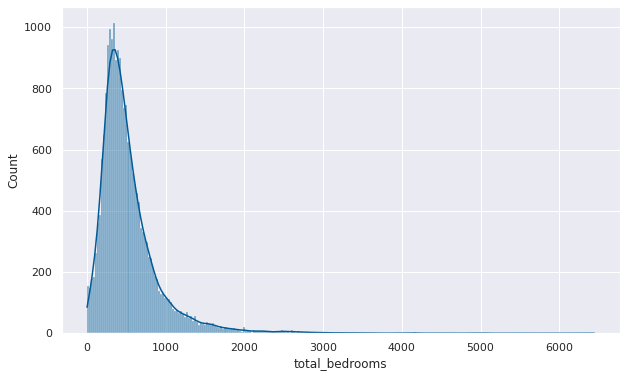

In [7]:
plt.figure(figsize= (10, 6))
sns.histplot(data['total_bedrooms'], color = '#005b96', kde= True);

It is definitely skewed, therefore we will fill missing values with median number of rooms within a block

In [8]:
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace= True)

## EDA

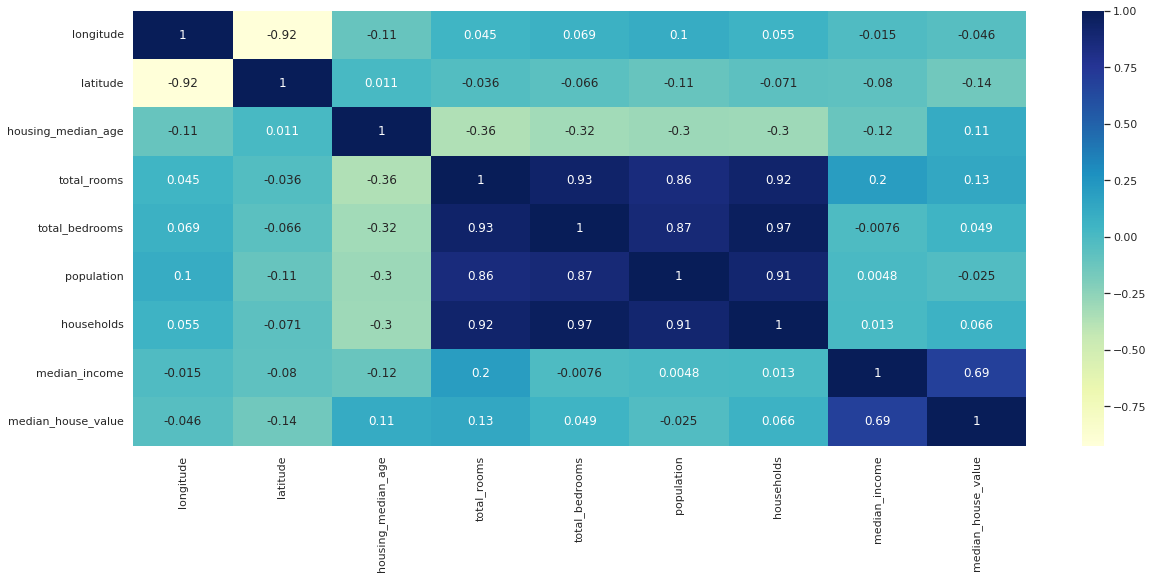

In [9]:
plt.figure(figsize= (20, 8))
sns.heatmap(data.corr(), annot= True, cmap='YlGnBu')
plt.show()

Median income is clearly our most important feature

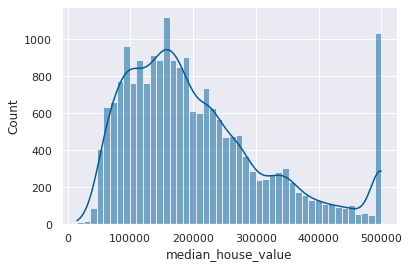

In [10]:
sns.histplot(data['median_house_value'], color = '#005b96', kde= True);

In [11]:
fig = px.scatter(data, x='longitude', y='latitude', color="population",labels="population")
fig.show()
print("need to scale")

need to scale


Our target variable is clearly skewed. Therefore we will apply log transformation to it later

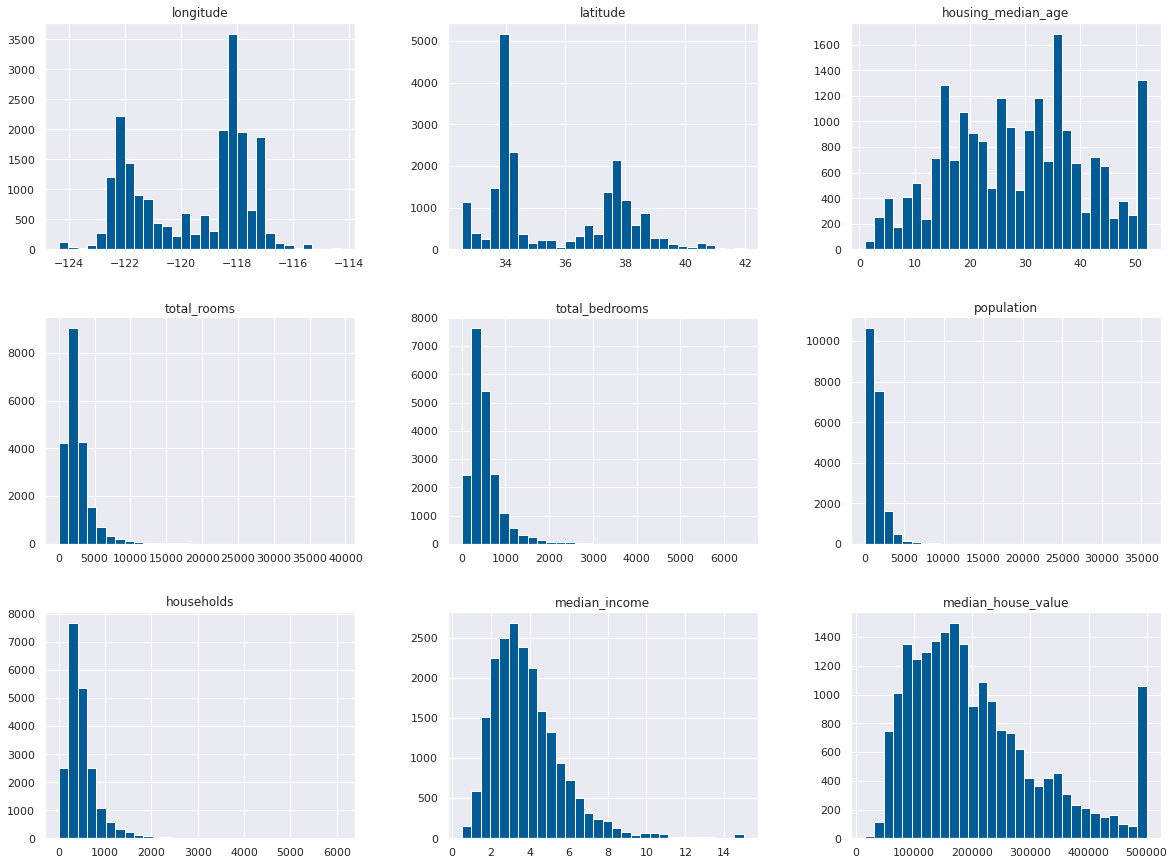

In [12]:
data.hist(bins = 30, figsize=(20, 15), color = '#005b96');

We can clearly see that lot of our features are skewed. Therefore, we will have to deal with it later when we will do feature transformation

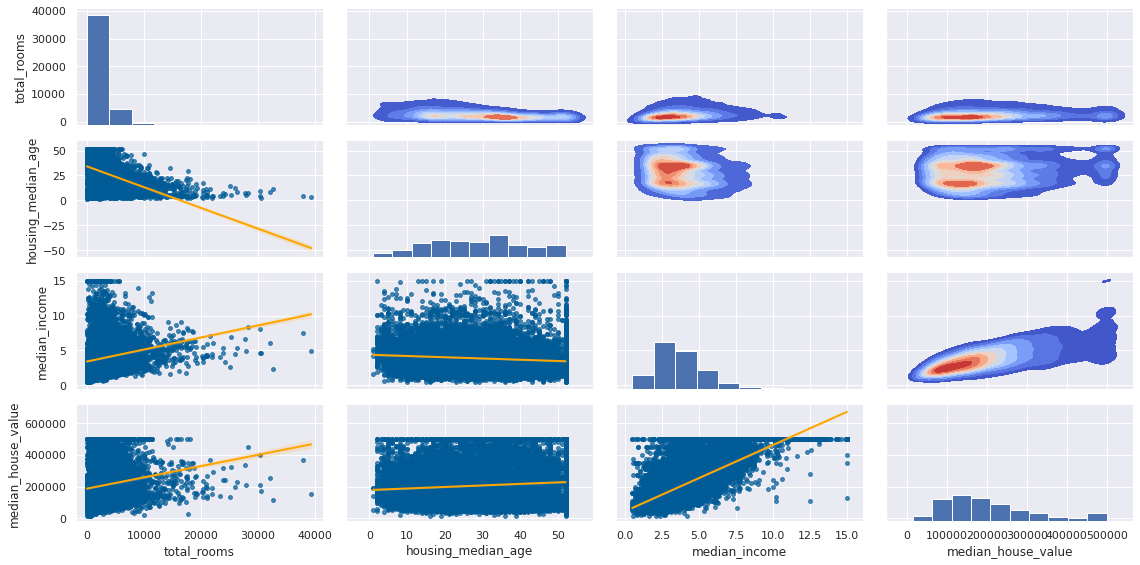

In [13]:
grid = sns.PairGrid(data, vars=['total_rooms', 'housing_median_age', 'median_income', 'median_house_value'],
                    height=2, aspect = 2)

grid = grid.map_diag(plt.hist)
grid = grid.map_lower(sns.regplot, scatter_kws = {'s': 15, 'alpha': 0.7, 'color': '#005b96'}, 
                      line_kws = {'color':'orange', 'linewidth': 2})
grid = grid.map_upper(sns.kdeplot, n_levels = 10, cmap= 'coolwarm', shade = True)

plt.show()

There are lots of outliers in our features. We will apply log transformation later to deal with it

## Confidence Interval

$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$
$CI$	=	confidence interval  
$\bar{x}$	=	sample mean  
$z$	=	confidence level value  
${s}$	=	sample standard deviation  
${n}$	=	sample size  

In [14]:
data_mhv = data['median_house_value']
n1,n2 = scipy.stats.t.interval(alpha=0.95, df=len(data_mhv)-1,loc=np.mean(data_mhv),scale=scipy.stats.sem(data_mhv))
print('The 95% confidence interval of the given data : ('+str(n1)+','+str(n2)+')')

The 95% confidence interval of the given data : (205281.44249335033,208430.19132447915)


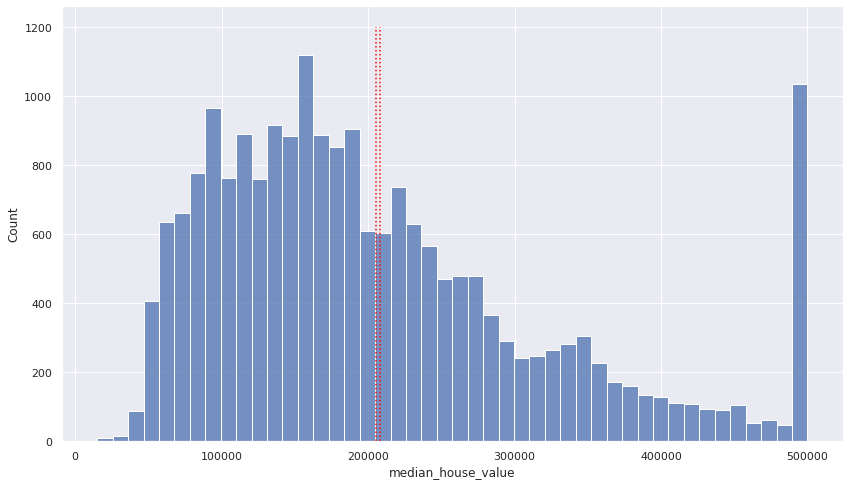

In [15]:
plt.figure(figsize= (14, 8))
sns.histplot(data['median_house_value'])

plt.plot([n1,n1],[0,1200],color='red',linestyle='dotted')
plt.plot([n2,n2],[0,1200],color='red',linestyle='dotted')

Let us also check out the categorical variable we have

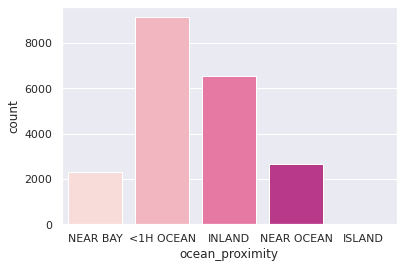

In [16]:
sns.countplot(x = data['ocean_proximity'], palette= 'RdPu');

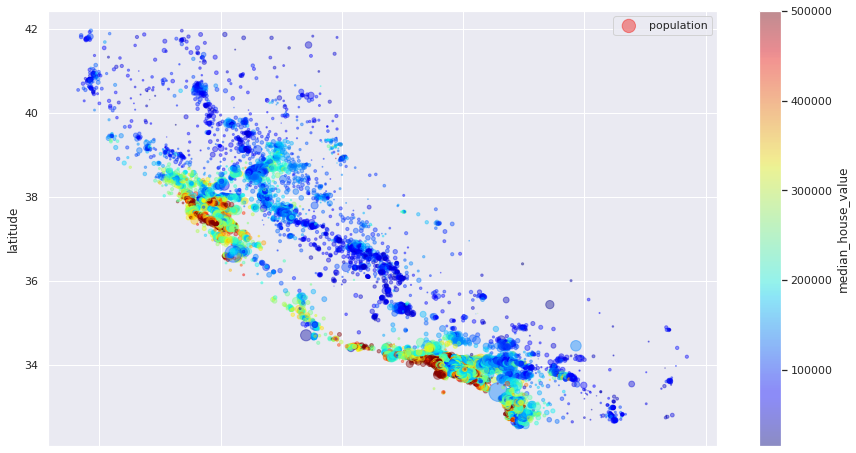

In [17]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=data["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

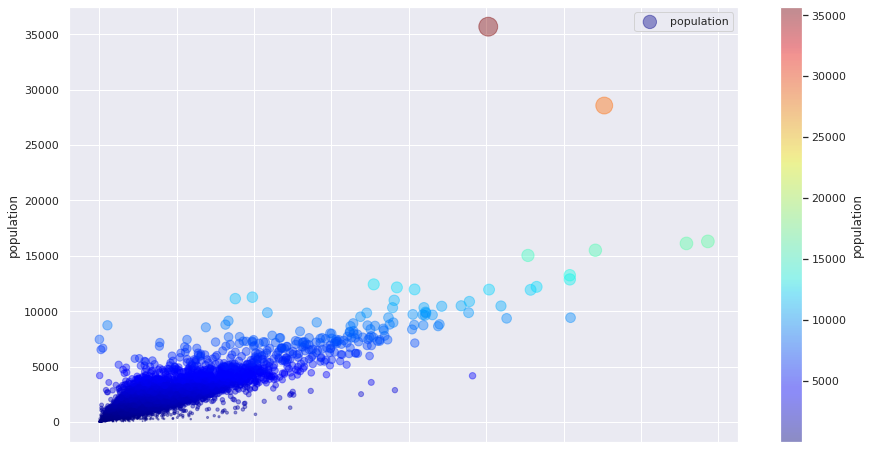

In [18]:
data.plot(kind="scatter", x="total_rooms", y="population", alpha=0.4,
         label="population", figsize=(15,8),s=data["population"]/100,
        c="population", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

# Again Clear cut outlier 

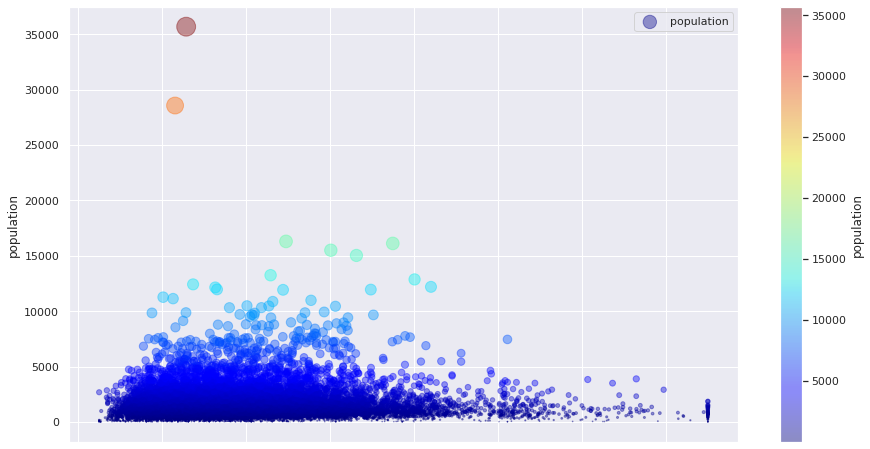

In [19]:
data.plot(kind="scatter", x="median_income", y="population", alpha=0.4,
         label="population", figsize=(15,8),s=data["population"]/100,
        c="population", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

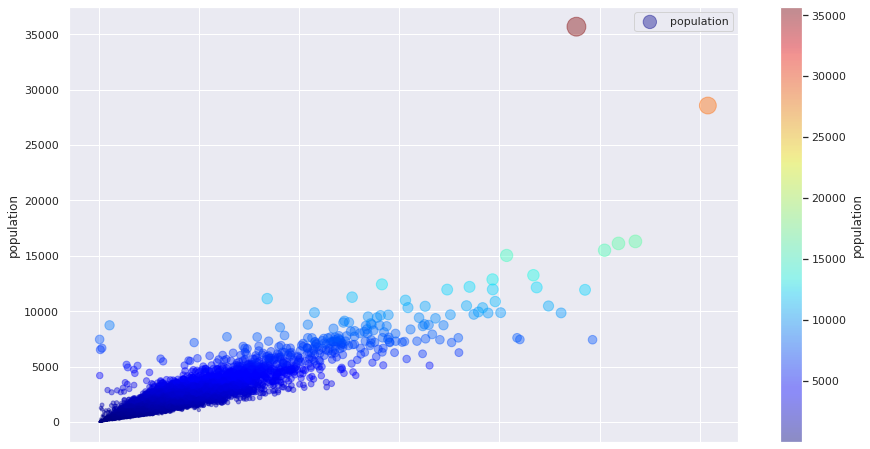

In [20]:
data.plot(kind="scatter", x="households", y="population", alpha=0.4,
         label="population", figsize=(15,8),
        c="population",s=data["population"]/100,  cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Feature Engineering

Make new features like square feet or longitude x latitude 

In [22]:
data['bed_per_room'] = data['total_bedrooms'] / data['total_rooms'] #very useful columns

In [23]:
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
bed_per_room          0
dtype: int64

In [24]:
X = data.drop(['median_house_value'], axis=1)
y = np.log(data.median_house_value) # Applying log transformation

## Feature Transformations

In [26]:
skew_df = pd.DataFrame(X.select_dtypes(np.number).columns, columns= ['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(X[feature]))
skew_df['Abs_Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Abs_Skew'].apply(lambda x: True if x > 0.5 else False)
skew_df

,Feature,Skew,Abs_Skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.480888,3.480888,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True
8,bed_per_room,6.316445,6.316445,True


In [27]:
skewed_columns = skew_df[skew_df['Abs_Skew'] > 0.5]['Feature'].values
skewed_columns

array(['total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'bed_per_room'], dtype=object)

In [28]:
for i in skewed_columns:
    print("Skewness of column : ",i, "is :",data[i].skew())

Skewness of column :  total_rooms is : 4.147343450632158
Skewness of column :  total_bedrooms is : 3.4811408631013117
Skewness of column :  population is : 4.93585822672712
Skewness of column :  households is : 3.410437711667147
Skewness of column :  median_income is : 1.6466567021344465
Skewness of column :  bed_per_room is : 6.316904041913851


### After Log transformation 

In [29]:
for column in skewed_columns:
    X[column] = np.log(X[column])

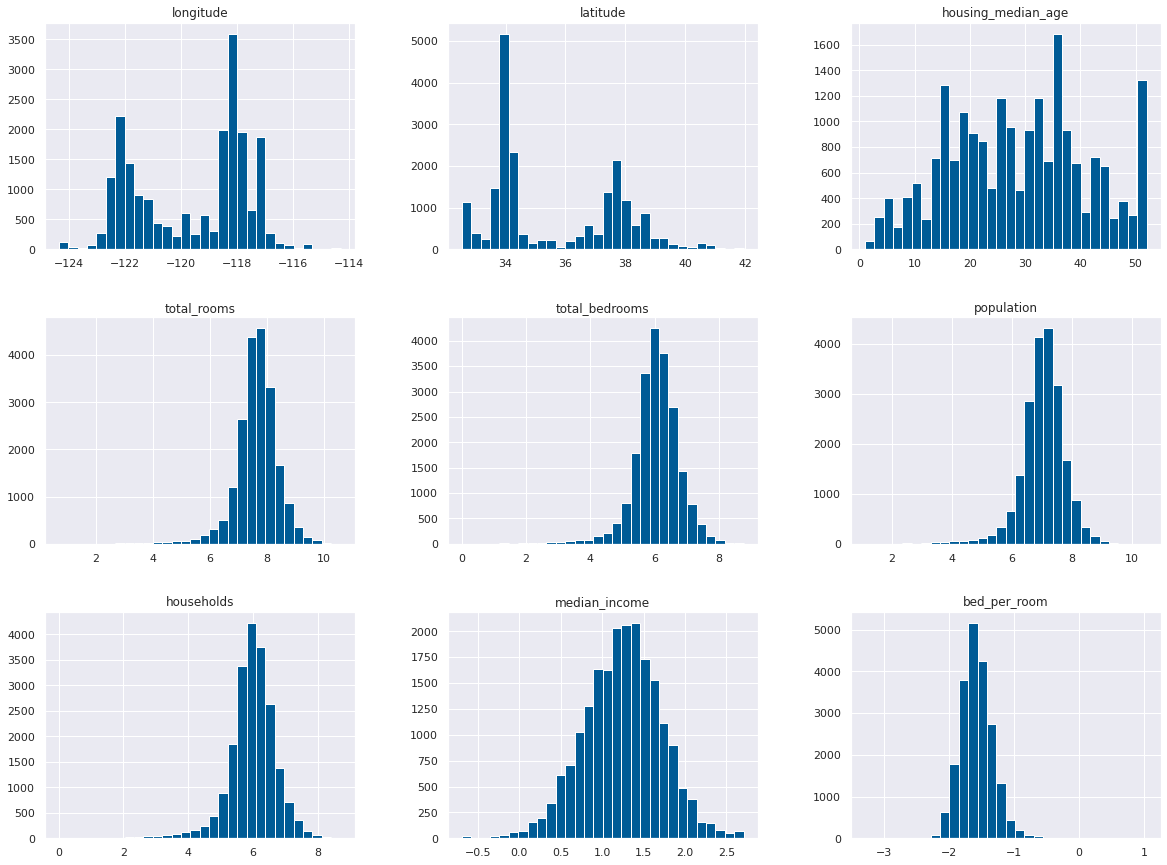

In [30]:
X.hist(bins = 30, figsize=(20, 15), color = '#005b96'); # slighlty left skewed

### Apply Log + Saqure Transformation

In [31]:
for col in skewed_columns[0:4]: # only first for 4 columns
    X[col]=np.square(X[col])

#### Now this is Good

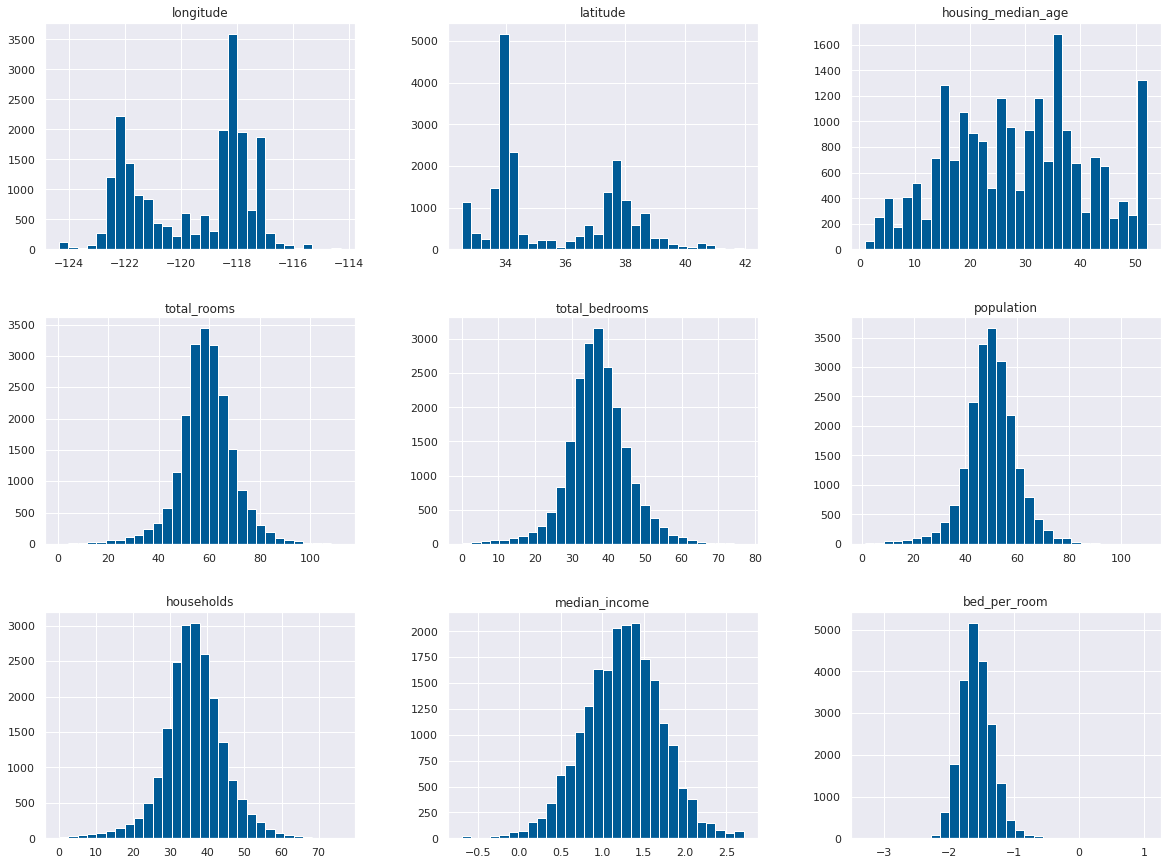

In [32]:
X.hist(bins = 30, figsize=(20, 15), color = '#005b96'); 

## Encoding

In [33]:
encoder=LabelEncoder()
X['ocean_proximity']=encoder.fit_transform(X['ocean_proximity'])

## Scaling

In [34]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bed_per_room
0,-122.23,37.88,41.0,45.967341,23.617777,33.345446,23.389623,2.119287,3,-1.920110
1,-122.22,37.86,21.0,78.636267,49.119145,60.585061,49.519758,2.116424,3,-1.859204
2,-122.24,37.85,52.0,53.158313,27.531262,38.521585,26.792526,1.982022,3,-2.043951
3,-122.25,37.85,52.0,51.121311,29.807074,39.997516,29.042094,1.730434,3,-1.690331
4,-122.25,37.85,52.0,54.678528,31.750854,40.155360,30.878338,1.347086,3,-1.759704


In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index= X.index, columns= X.columns)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Linear Regression

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)


In [39]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_lr))
r2 = r2_score(y_test, predictions_lr)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.3429361638924436
R-square: 0.6376537897318297


## Feature Selection

In [40]:
perm = PermutationImportance(lr, random_state=42)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.to_list())

Weight,Feature
2.0341 ± 0.0919,latitude
1.7356 ± 0.0598,longitude
0.8559 ± 0.0175,median_income
0.4939 ± 0.0182,total_bedrooms
0.4791 ± 0.0237,population
0.0879 ± 0.0059,households
0.0610 ± 0.0062,total_rooms
0.0117 ± 0.0043,housing_median_age
0.0034 ± 0.0009,ocean_proximity
-0.0028 ± 0.0016,bed_per_room


## KNN

In [41]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)

In [42]:
perm = PermutationImportance(knn, random_state=42)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.to_list())

Weight,Feature
0.4885 ± 0.0149,median_income
0.4092 ± 0.0137,ocean_proximity
0.3978 ± 0.0271,latitude
0.2227 ± 0.0138,longitude
0.1027 ± 0.0086,population
0.0904 ± 0.0131,housing_median_age
0.0387 ± 0.0065,total_bedrooms
0.0323 ± 0.0065,households
0.0278 ± 0.0023,bed_per_room
0.0262 ± 0.0053,total_rooms


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_knn))
r2 = r2_score(y_test, predictions_knn)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.280277415006533
R-square: 0.7579676825607957


## Random Forest

In [44]:
rf = RandomForestRegressor(n_estimators= 100)
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

In [45]:
perm = PermutationImportance(rf, random_state=42)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.to_list())

Weight,Feature
0.6093 ± 0.0255,median_income
0.3246 ± 0.0092,longitude
0.3029 ± 0.0118,latitude
0.2982 ± 0.0142,ocean_proximity
0.0338 ± 0.0019,bed_per_room
0.0334 ± 0.0038,housing_median_age
0.0216 ± 0.0022,population
0.0085 ± 0.0010,total_rooms
0.0062 ± 0.0010,households
0.0059 ± 0.0010,total_bedrooms


In [46]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_rf))
r2 = r2_score(y_test, predictions_rf)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.23246031766306952
R-square: 0.8335074494902361


## CatBoost

In [47]:
catboost = CatBoostRegressor(verbose= 0)
catboost.fit(X_train, y_train)
predictions_cb = catboost.predict(X_test)

In [48]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_cb))
r2 = r2_score(y_test, predictions_cb)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.22051178290332887
R-square: 0.8501831181627162


## XGBoost

In [49]:
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)
predictions_xgb = xgboost.predict(X_test)

In [50]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_xgb))
r2 = r2_score(y_test, predictions_xgb)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.2287827738236581
R-square: 0.8387336357690659


## LightGBM

In [51]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
predictions_lgb = lgb.predict(X_test)

In [52]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_lgb))
r2 = r2_score(y_test, predictions_lgb)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.2320773414036265
R-square: 0.8340555875176672


## Gradient Boosting

In [53]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
predictions_gbr = gbr.predict(X_test)

In [54]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_gbr))
r2 = r2_score(y_test, predictions_gbr)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.26773896458293417
R-square: 0.7791383504266383


Performance of catboost, xgboost, LightGBM and random forest clearly ourperforms the multiple linear regression, knn and gradient boosting. So lets combine these 4 models to get the final predictions

In [55]:
final_predictions = (
    0.25 * predictions_cb+
    0.25 * predictions_rf+
    0.25 * predictions_xgb+
    0.25 * predictions_lgb
)

In [56]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
r2 = r2_score(y_test, final_predictions)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.21937263165425522
R-square: 0.8517270108779326


In [57]:
final_predictions

array([10.9102701 , 11.25400493, 13.06532935, ..., 13.12527043,
       11.2295515 , 12.02951631])

We will have to take exponent of our final predictions to get them back to our original scale

In [58]:
final_predictions = np.exp(final_predictions)
y_test = np.exp(y_test)

In [59]:
pd.DataFrame({'Actual': y_test, 'Predicted': final_predictions.round(2)})

,Actual,Predicted
20046,47700.0,54735.63
3024,45800.0,77188.44
15663,500001.0,472280.96
20484,218600.0,254026.75
9814,278000.0,258355.54
...,...,...
15362,263300.0,242786.30
16623,266800.0,221861.83
18086,500001.0,501455.64
2144,72300.0,75323.81


## Visualising the result

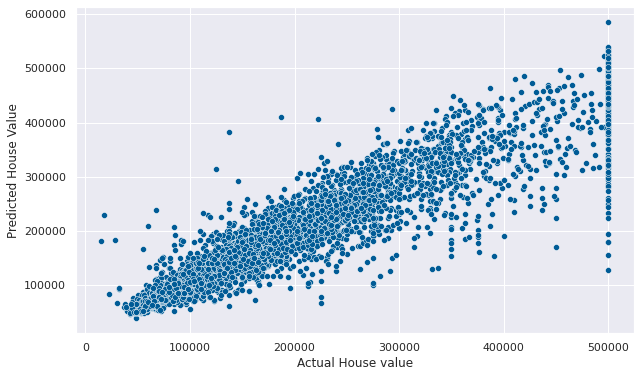

In [60]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual House value')
plt.ylabel('Predicted House Value')
plt.show()

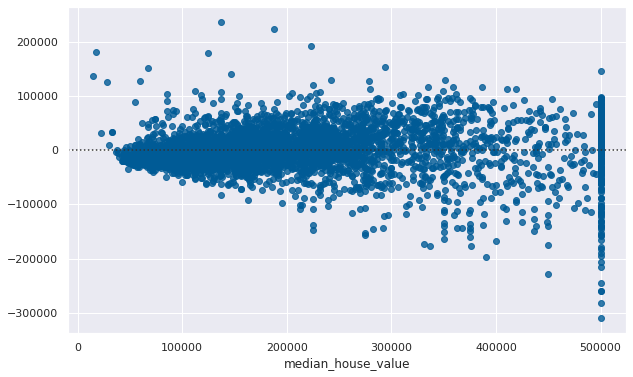

In [61]:
plt.figure(figsize= (10, 6))
sns.residplot(x= y_test, y = final_predictions, color= '#005b96')
plt.show()

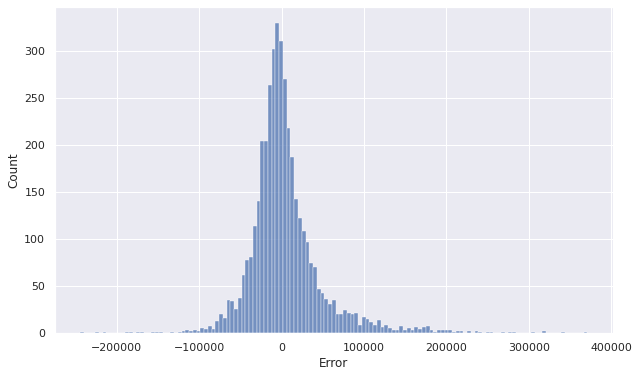

In [62]:
resid = y_test - final_predictions
plt.figure(figsize= (10, 6))
sns.histplot(resid)
plt.xlabel('Error');

Distribution of errors seems like normal, so our model is doing a decent job.